In [155]:
import numpy as np
import pandas as pd

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from modAL.models import Committee
from modAL.disagreement import vote_entropy_sampling


from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import sklearn.linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support
import xgboost as xgb
from sklearn.model_selection import GridSearchCV


import recordlinkage as rl

from IPython import display
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [35]:
df_uns = pd.read_csv(r'C:\Users\Invitado\Documents\Python\DS_MASTER\City_Adam_Intern\df_uns_label_img_1.csv')
df_full = pd.read_csv(r'C:\Users\Invitado\Documents\Python\DS_MASTER\City_Adam_Intern\merged_clean_df.csv')
df_full.drop('Unnamed: 0',axis=1,inplace=True)

#Manually annotated data
test_1 = rl.read_annotation_file(r'C:\Users\Invitado\Documents\Python\DS_MASTER\City_Adam_Intern\result_bnb_trip.json')
test_2 = rl.read_annotation_file(r'C:\Users\Invitado\Documents\Python\DS_MASTER\City_Adam_Intern\result_bnb_vrb.json')

#Baselines fully labeled
df_base_train = pd.read_csv(r'C:\Users\Invitado\Documents\Python\DS_MASTER\City_Adam_Intern\UnsupervisedBootAL-master\datasets\wdc_product\features_phones_phones_catalog_train')
df_base_test = pd.read_csv(r'C:\Users\Invitado\Documents\Python\DS_MASTER\City_Adam_Intern\UnsupervisedBootAL-master\datasets\wdc_product\features_phones_phones_catalog_test')
#Baseline with unsupervised
df_full_base = pd.read_csv(r'C:\Users\Invitado\Documents\Python\DS_MASTER\City_Adam_Intern\df_uns_label_base_train.csv')
df_full_base['label'] = df_full_base['label'].map(to_bin)

In [36]:
df_base_train = df_full_base.loc[:1761]
df_base_test = df_full_base.loc[1762:]

In [42]:

def compare(df,id_1,id_2,full =False):
    link = [x for x in df_full['listing_url'][df_full['ListingId']==id_1]]
    link_2 = [x for x in df_full['listing_url'][df_full['ListingId']==id_2]]
    
    if full == True:
    #Compare URLS
        lista = [print(x,':',y,'==',z) for x,y,z in zip(df.columns.tolist(),
                                                        df[df['ListingId'] == id_1].values.tolist()[0],
                                                        df[df['ListingId'] == id_2].values.tolist()[0])]
        return 'Full info retrieved'
    else:
        print(link[0])
        print(link_2[0])
        return 'Links retreived'
        

compare(df_full,10161202, 10161074,full=False)

https://www.airbnb.nl/rooms/10161202
https://www.airbnb.nl/rooms/10161074


'Links retreived'

In [28]:
#Take out the labeled data for making a test set 
manual_labeled = []

#Getting the Listing Ids bc the files is in index 
for x,y in test_1.links:
    tuple_1 = (df_full['ListingId'].iloc[x],df_full['ListingId'].iloc[y])
    tuple_2 = (df_full['ListingId'].iloc[y],df_full['ListingId'].iloc[x])
    manual_labeled.append([str(tuple_1),1])
    manual_labeled.append([str(tuple_2),1])
    
for x,y in test_2.links:
    tuple_1 = (df_full['ListingId'].iloc[x],df_full['ListingId'].iloc[y])
    tuple_2 = (df_full['ListingId'].iloc[y],df_full['ListingId'].iloc[x])
    manual_labeled.append([str(tuple_1),1])
    manual_labeled.append([str(tuple_2),1])
for x,y in test_1.distinct:
    tuple_1 = (df_full['ListingId'].iloc[x],df_full['ListingId'].iloc[y])
    tuple_2 = (df_full['ListingId'].iloc[y],df_full['ListingId'].iloc[x])
    manual_labeled.append([str(tuple_1),0])
    manual_labeled.append([str(tuple_2),0])
    
for x,y in test_2.distinct:
    tuple_1 = (df_full['ListingId'].iloc[x],df_full['ListingId'].iloc[y])
    tuple_2 = (df_full['ListingId'].iloc[y],df_full['ListingId'].iloc[x])
    manual_labeled.append([str(tuple_1),0])
    manual_labeled.append([str(tuple_2),0])

 #Merging to have it with the full data   
df_labeled = pd.DataFrame(manual_labeled,columns=['ids','labels'])
df_labeled
with_labels =df_uns.merge(df_labeled,on='ids',how='left')


In [122]:
"""import pickle
# Saving labels as pickle
file_name = "vic_labels.pkl"
open_file = open(file_name, "wb")
pickle.dump(manual_labeled, open_file)
open_file.close()"""

df_labeled

,ids,labels
0,"(11252596, 21319730)",1
1,"(21319730, 11252596)",1
2,"(14548324, 18113908)",1
3,"(18113908, 14548324)",1
4,"(14548324, 18285070)",1
...,...,...
465,"(10917883, 43763917)",0
466,"(21198240, 7662177)",0
467,"(7662177, 21198240)",0
468,"(9530785, 1037906)",0


In [186]:
#Baseline models data
not_train = ['source_id','target_id','ids', 'agg_score', 'weights','uns_label','label']
X_train = df_base_train.drop(not_train, axis=1).values
y_train = df_base_train['label'].values
X_test = df_base_test.drop(not_train, axis=1).values
y_test = df_base_test['label'].values

In [187]:
#Decision Tress serach for hyperparameters
params = {'max_leaf_nodes': list(range(2, 100)),'max_depth' : [None, 3, 5, 10, 15], 
        'min_samples_leaf' : [3, 5, 10], 'criterion' : ['gini', 'entropy']}

grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)
grid_search_cv.fit(X_train, y_train)
#Best parameters
print(grid_search_cv.best_params_)
#Get the perd metrics of the model 
y_pred = grid_search_cv.predict(X_test)
precision_recall_fscore=precision_recall_fscore_support(y_test,y_pred,average='binary',zero_division=0)
print('Precision:',precision_recall_fscore[0],
      'Recall:',precision_recall_fscore[1],
      'Fscore:',precision_recall_fscore[2])

Fitting 3 folds for each of 2940 candidates, totalling 8820 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'criterion': 'gini', 'max_depth': None, 'max_leaf_nodes': 7, 'min_samples_leaf': 3}
Precision: 0.7884615384615384 Recall: 0.803921568627451 Fscore: 0.7961165048543688


[Parallel(n_jobs=1)]: Done 8820 out of 8820 | elapsed:  2.5min finished


In [189]:
# Logistic Reg search for hyperparameters
params = {'penalty' :['l1', 'l2'],'fit_intercept' : [True, False],
        'solver' :['liblinear', 'saga'],'max_iter' : [50, 100, 150]}

grid_search_cv = GridSearchCV(LogisticRegression(random_state=42), params, verbose=1, cv=3)
grid_search_cv.fit(X_train, y_train)
#Best parameters
print(grid_search_cv.best_params_)
#Get the perd metrics of the model 
y_pred = grid_search_cv.predict(X_test)
precision_recall_fscore=precision_recall_fscore_support(y_test,y_pred,average='binary',zero_division=0)
print('Precision:',precision_recall_fscore[0],
      'Recall:',precision_recall_fscore[1],
      'Fscore:',precision_recall_fscore[2])

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   16.7s finished


{'fit_intercept': True, 'max_iter': 150, 'penalty': 'l1', 'solver': 'saga'}
Precision: 0.7959183673469388 Recall: 0.7647058823529411 Fscore: 0.7799999999999999


In [193]:
# SVM search for hyperparameters
params = {'kernel':['linear', 'rbf'], 'gamma':[0.1, 1, 5, 10] ,'C' : [0.5, 1, 5, 10]}

grid_search_cv = GridSearchCV(SVC(random_state=42), params, verbose=1, cv=3)
grid_search_cv.fit(X_train, y_train)
#Best parameters
print(grid_search_cv.best_params_)
#Get the perd metrics of the model 
y_pred = grid_search_cv.predict(X_test)
precision_recall_fscore=precision_recall_fscore_support(y_test,y_pred,average='binary',zero_division=0)
print('Precision:',precision_recall_fscore[0],
      'Recall:',precision_recall_fscore[1],
      'Fscore:',precision_recall_fscore[2])


Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'C': 1, 'gamma': 0.1, 'kernel': 'linear'}
Precision: 0.7884615384615384 Recall: 0.803921568627451 Fscore: 0.7961165048543688


[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:   26.7s finished


In [195]:
# XGBoost search for hyperparameters
params = {'n_estimators':[100, 150, 200],'learning_rate':[0.05, 0.1, 0.15],'max_depth':[3, 5, 7]}


grid_search_cv = GridSearchCV(xgb.XGBClassifier(random_state=42), params, verbose=1, cv=3)
grid_search_cv.fit(X_train, y_train)
#Best parameters
print(grid_search_cv.best_params_)
#Get the perd metrics of the model 
y_pred = grid_search_cv.predict(X_test)
precision_recall_fscore=precision_recall_fscore_support(y_test,y_pred,average='binary',zero_division=0)
print('Precision:',precision_recall_fscore[0],
      'Recall:',precision_recall_fscore[1],
      'Fscore:',precision_recall_fscore[2])


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:  1.2min finished


{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150}
Precision: 0.8461538461538461 Recall: 0.8627450980392157 Fscore: 0.854368932038835


In [196]:
# Random Forest search for hyperparameters
params = {'n_estimators':[10, 50, 100] ,'max_depth':[None, 3, 5, 10, 15],'min_samples_leaf':[3, 5, 10]}

grid_search_cv = GridSearchCV(RandomForestClassifier(random_state=42), params, verbose=1, cv=3)
grid_search_cv.fit(X_train, y_train)
#Best parameters
print(grid_search_cv.best_params_)
#Get the perd metrics of the model 
y_pred = grid_search_cv.predict(X_test)
precision_recall_fscore=precision_recall_fscore_support(y_test,y_pred,average='binary',zero_division=0)
print('Precision:',precision_recall_fscore[0],
      'Recall:',precision_recall_fscore[1],
      'Fscore:',precision_recall_fscore[2])

Fitting 3 folds for each of 45 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 50}
Precision: 0.8297872340425532 Recall: 0.7647058823529411 Fscore: 0.7959183673469387


[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:   26.5s finished


In [197]:
#Comitee of models
def randomforest():
    clf = RandomForestClassifier(random_state=1,n_estimators=10,min_samples_split=2,warm_start=True,max_depth=5)
    return clf
def desiciontree():
    clf= DecisionTreeClassifier(random_state=1,criterion ='gini', max_depth= None,max_leaf_nodes= 7,
                              min_samples_leaf= 3)
    return clf
def logisticreg():
    clf = LogisticRegression(random_state=1,fit_intercept= True,max_iter=150,
                             penalty= 'l1',solver= 'saga')
    return clf
def xbg_class():
    clf = xgb.XGBClassifier(random_state=1,learning_rate=0.1,max_depth= 7,n_estimators = 150)
    return clf
def svm():
    clf = SVC(probability=True,C= 1,gamma= 0.1, kernel= 'linear')
    return clf

In [278]:
def al(df,df_test = False,queries = 20,baseline=False):
    
    #Commitee of models
    members = [randomforest,desiciontree,logisticreg,xbg_class,svm]
    #List with comitee object
    learner_list = list()
    
    if baseline == False:
        #Only use the data corresponding to the features to train
        not_train = ['ListingId_1','ListingId_2','ids', 'agg_score', 'weights','uns_label','labels']
    else:
        #Only use the data corresponding to the features to train
        not_train = ['source_id','target_id','ids', 'agg_score', 'weights','uns_label','label']
        
    ids = df['ids'].values
    X_pool = df.drop(not_train, axis=1).values
    y_uns_label = df['uns_label'].values
    y_uns_weight = df['weights'].values
    
    if baseline == False:
        #Create the test set , select the not nan values
        y_test_1= df['labels'].values
        idx = np.argwhere(~np.isnan(y_test_1)).reshape(-1)
        y_test= y_test_1[idx]
        X_test = X_pool[idx]
        #Eliminate from the main data variables the test data extracted
        X_pool = np.delete(X_pool, np.argwhere(~np.isnan(y_test_1)), axis=0)
        y_uns_label = np.delete(y_uns_label, np.argwhere(~np.isnan(y_test_1)), axis=0)
        y_uns_weight = np.delete(y_uns_weight, np.argwhere(~np.isnan(y_test_1)), axis=0)
        ids = np.delete(ids, np.argwhere(~np.isnan(y_test_1)), axis=0)
    else:
        y_pool_labels = df['label'].values
        y_test = df_test['label'].values
        X_test = df_test.drop(not_train, axis=1).values

    for clf in members:
        # initial training data
        #Selcting the most confident unsupervised labels for initial training
        if clf == randomforest:

            X_train = X_pool
            y_train = y_uns_label
            
            """train_idx = np.where(y_uns_weight> 0.99998)
            X_train = X_pool[train_idx]
            y_train = y_uns_label[train_idx]"""
            
            # initializing learner
            learner = ActiveLearner(
                estimator=clf(),
                X_training=X_train, y_training=y_train
                #sample_weight= y_uns_weight
            )
            learner_list.append(learner)

        else:
            
            """X_train = X_pool
            y_train = y_uns_label"""
            
            train_idx = np.where(y_uns_weight> 0.99998)
            X_train = X_pool[train_idx]
            y_train = y_uns_label[train_idx]
            
            # initializing learner
            learner = ActiveLearner(
                estimator=clf(),
                X_training=X_train, y_training=y_train
            )
            learner_list.append(learner)

    # assembling the committee
    committee = Committee(learner_list=learner_list,query_strategy=vote_entropy_sampling)
    
    #committee.rebag()
    #Will save the new labels being labeled
    new_labels = []
    
    # we want to only use the prediction of the random forest which will be incrementally built
    """for x in committee:
        if type(x.get_params()['estimator'])== sklearn.ensemble._forest.RandomForestClassifier:
            #Get predictions of test set 
            y_pred = x.predict(X_test)
            precision_recall_fscore= precision_recall_fscore_support(y_test,y_pred,average='binary',zero_division=0)
            #Calculate metrics
            precision_scores = [precision_recall_fscore[0]]
            recall_scores=  [precision_recall_fscore[1]]
            f_score = [precision_recall_fscore[2]]
    """
    y_pred = committee.predict(X_test)
    precision_recall_fscore= precision_recall_fscore_support(y_test,y_pred,average='binary',zero_division=0)
    #Calculate metrics
    precision_scores = [precision_recall_fscore[0]]
    recall_scores=  [precision_recall_fscore[1]]
    f_score = [precision_recall_fscore[2]]
    
    
    # query by committee
    n_queries = queries
    #Active Learning Loop
    for idx in range(n_queries):
        # Committee models gives the instance to be labeled
        query_idx, query_instance = committee.query(X_pool)
        
        #For AMS data we need to query the user directly 
        if baseline == False:
            #This asks for a label
            print("Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info")
            ids_int = [int(x) for x in ids[query_idx[0]][1:-1].split(',')]
            print(compare(df_full,ids_int[0],ids_int[1]))
            label = int(input())
            if label == 2:
                print(compare(df_full,ids_int[0],ids_int[1],full=True))
                label = int(input())
            y_new = np.array([label], dtype=int)

        if baseline == True:
            #For baseline we can access the true labels no need to ask just retreive
            label = y_pool_labels[query_idx[0]]
            y_new = np.array([label], dtype=int)
        
        for model in committee:
            #Train the random forest in incremental way with the labeled instance
            if type(model.get_params()['estimator'])== sklearn.ensemble._forest.RandomForestClassifier:
                
                #Teach the random forest , boostrap true is incremental
                model.teach(query_instance.reshape(1, -1), y_new)
                
                n_estimators = model.get_params()['estimator__n_estimators'] +2 
                params_rf = {'estimator__n_estimators':n_estimators} #,'estimator__max_depth': n_estimators
                model.set_params(**params_rf)
                
         
                #Predict with the new instance 
                # we want to only use the prediction of the random forest which will be incrementally built
                
                """y_pred = model.predict(X_test)
                precision_recall_fscore=precision_recall_fscore_support(y_test,y_pred,average='binary',zero_division=0)

                precision_scores.append(precision_recall_fscore[0])
                recall_scores.append(precision_recall_fscore[1])
                f_score.append(precision_recall_fscore[2])"""
            else:
                
                model.teach(query_instance.reshape(1, -1), y_new)
        
        y_pred = committee.predict(X_test)
        precision_recall_fscore=precision_recall_fscore_support(y_test,y_pred,average='binary',zero_division=0)

        precision_scores.append(precision_recall_fscore[0])
        recall_scores.append(precision_recall_fscore[1])
        f_score.append(precision_recall_fscore[2])
        
        
        #Delete the queried instance from the pool
        X_pool = np.delete(X_pool, query_idx, axis=0)
                
        if baseline == True:
            #For the baseline we need to delete the label learned from the pool
            y_pool_labels = np.delete(y_pool_labels, query_idx, axis=0)
            
    
        if baseline ==False:
            new_labels.append([(ids_int[0],ids_int[1]),label])
    
    #Graph to check the learning process
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(5, 5))
        plt.subplot(1, 1, 1)
        plt.title('Precision of your model')
        plt.plot(range(n_queries+1), precision_scores)
        #plt.scatter(range(n_queries+1), precision_scores)
        plt.xlabel('number of queries')
        plt.ylabel('Precision')
        display.display(plt.gcf())
        plt.close('all')
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(5, 5))
        plt.subplot(1, 1, 1)
        plt.title('recall_scores of your model')
        plt.plot(range(n_queries+1), recall_scores)
        #plt.scatter(range(n_queries+1), recall_scores)
        plt.xlabel('number of queries')
        plt.ylabel('recall_scores')
        display.display(plt.gcf())
        plt.close('all')
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(5, 5))
        plt.subplot(1, 1, 1)
        plt.title('f_score of your model')
        plt.plot(range(n_queries+1), f_score)
        #plt.scatter(range(n_queries+1), f_score)
        plt.xlabel('number of queries')
        plt.ylabel('f_score')
        display.display(plt.gcf())
        plt.close('all')
    return new_labels

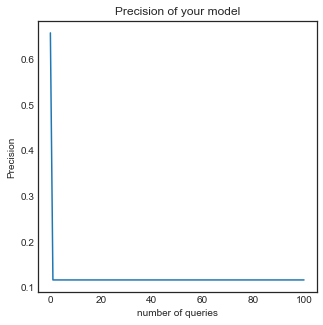

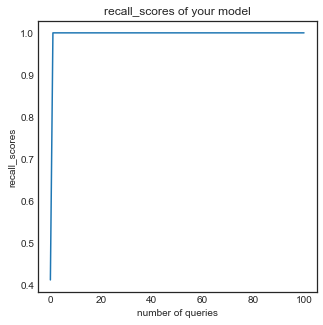

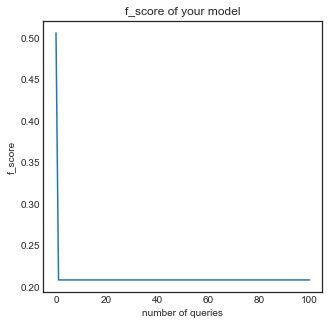

[]

In [279]:
#weights in Random Forest , no boostrapping, Comitee Forest pred
al(df_base_train,df_test = df_base_test,queries=100,baseline=True)

{0.0, 1.0}


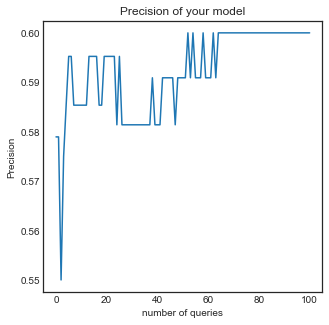

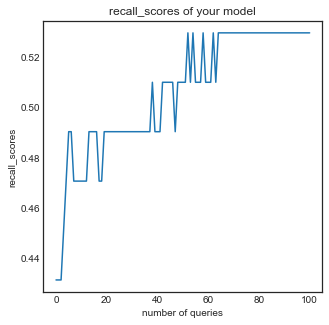

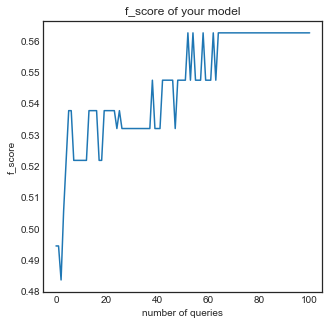

[]

In [267]:
#weights in Random Forest , no boostrapping, Random Forest pred
al(df_base_train,df_test = df_base_test,queries=100,baseline=True)

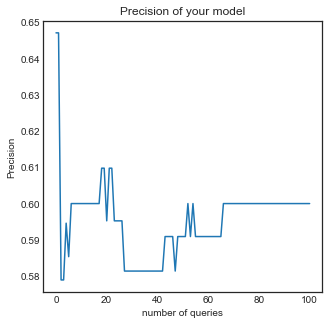

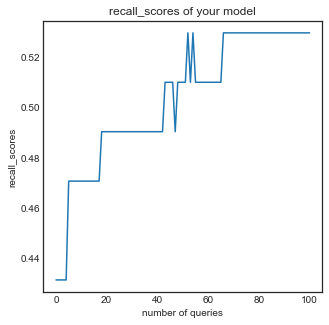

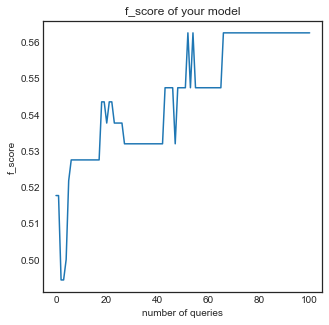

[]

In [263]:
#No weights in Random Forest, Random Forest pred
al(df_base_train,df_test = df_base_test,queries=100,baseline=True)

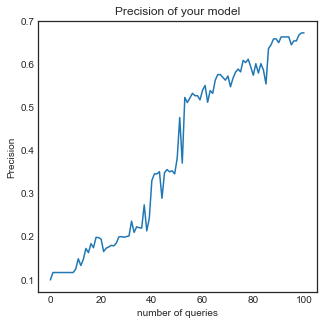

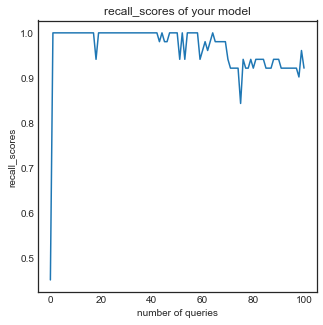

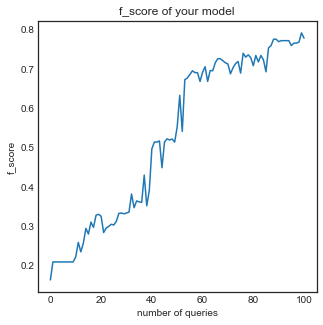

[]

In [273]:
#All committes pred, ony trained on most confident
al(df_base_train,df_test = df_base_test,queries=100,baseline=True)

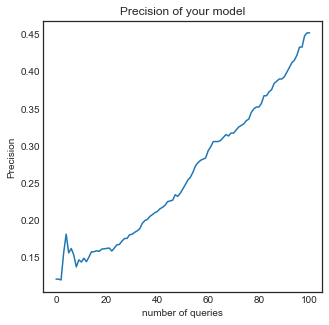

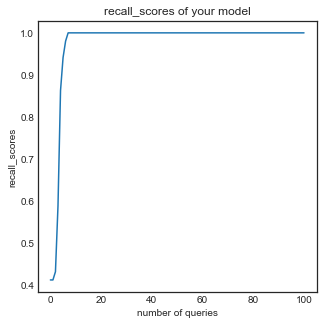

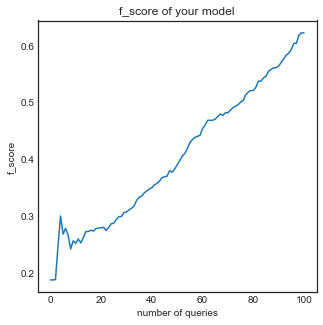

[]

In [275]:
#Random Forest pred, ony trained on most confidents first, # increasing depth
al(df_base_train,df_test = df_base_test,queries=100,baseline=True)